# Inicialización

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')  # allow importing from parent directory
from fun_gilles import *
import cmcrameri.cm as cmc
import pickle
import pandas as pd

In [100]:
def plot_barrido(c_inicial, c_equilibrio, species):
    colors = cmc.berlin(np.linspace(0, 1, len(species)))

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8), sharex=True)
    
    n_conditions = np.arange(len(c_inicial))
    
    # --- Subplot 1: condiciones iniciales ---
    ax1 = axes[0]
    for i in range(len(species)):
        ax1.plot(n_conditions, c_inicial[:, i], label=species[i], color=colors[i], alpha=0.9, marker= "s")
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.set_xlabel("Simulation")
    ax1.set_ylabel("Initial concentration")
    ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title="Species")
    
    ax2 = axes[1]
    for i in range(len(species)):
        ax2.plot(n_conditions, c_equilibrio[:, i], label=species[i], color=colors[i], alpha=0.9, marker= "s")
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.set_xlabel("Simulation")
    ax2.set_ylabel("Equilibrium concentration")    

In [101]:
def plot_volume(v_f,ab_initial):
    
    # --- Plot ---
    plt.plot(ab_initial, v_f, color= "slategray", marker= "s")
    plt.xlabel("Initial [ab]")
    plt.ylabel("Volume at t = 10")


In [102]:
def plot(abundances, times, V, species):
    colors = cmc.berlin(np.linspace(0, 1, len(species)))

    # --- Create the figure and a 1-row, 3-column subplot grid ---
    # Using a wide figsize for a horizontal layout.
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True) 
    # Note: sharex=True is removed because we need the x-axis ticks on all three plots, 
    # although they are the same (time).

    # --- Subplot 1 (Left): Concentration ---
    ax1 = axes[0]
    for i in range(len(species)):
        # Calculate Concentration = Abundance / Volume
        ax1.plot(times, abundances[:, i] / V, label=species[i], color=colors[i], alpha=0.9)
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Concentration")
    ax1.set_title("Concentration Evolution")
    ax1.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), title="Species")


    # --- Subplot 2 (Middle): Volume ---
    ax2 = axes[1]
    ax2.plot(times, V, color='gray')
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Volume")
    ax2.set_yscale("log")
    ax2.set_title("Volume Evolution")


    # --- Final Touches ---
    # Add a figure-wide title
    fig.suptitle(fr"Simulation Results ($K_1$ = {round(k[1]/k[0])}, $K_2$ = {round(k[3]/k[2])}, $K_3$ = {round(k[5]/k[4])}, $K_4$ = {round(k[7]/k[6])})",
                 fontsize=16)

    # Adjust layout to prevent labels/titles from overlapping
    plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust tight_layout for a single row

    plt.show()

In [103]:
def plot_volume_vs_k(v_f,k_i,k, i):
    
    # --- Plot ---
    plt.plot(k_i/k[i+1], v_f, color= "slategray", marker= "s")
    plt.xlabel(fr"$K_{round(i/2)+1}$")
    plt.ylabel("Volume at t = 10")
    plt.xscale("log")

In [104]:
f = '../examples/reactions_autocat.txt'
reactions = read_file(f)
species = obtain_species(reactions)

# barrido

In [10]:
with open("../barrido_ab.txt", "rb") as file:
    barrido_ab = pickle.load(file)

with open("../barrido_k0.txt", "rb") as file:
    barrido_k0 = pickle.load(file)
    
with open("../barrido_k2.txt", "rb") as file:
    barrido_k2 = pickle.load(file)

## ajuste a log

In [86]:
from numpy.polynomial.polynomial import polyfit

def get_alpha(volumes, times):
    # 1. Transform the data
    log_v = np.log(volumes)
    
    # 2. Perform linear regression: log(V) = log(A) + m * t
    coefficients = polyfit(times, log_v, 1)
    
    # Extract the intercept (log(A)) and slope (m)
    log_A_fit = coefficients[0]
    m_fit = coefficients[1] 
    
    # 3. Calculate the scaling constant A
    A_fit = np.exp(log_A_fit)
    
    
    # --- R-SQUARED CALCULATION ---
    
    # a) Calculate the predicted log(V) values
    # log(V)_predicted = log(A)_fit + m_fit * t
    log_v_predicted = log_A_fit + m_fit * times
    
    # b) Calculate the Mean of the actual log(V) data
    log_v_mean = np.mean(log_v)
    
    # c) Calculate Sum of Squares of Residuals (SS_res)
    # The sum of the squared differences between actual y and predicted y
    SS_res = np.sum((log_v - log_v_predicted)**2)
    
    # d) Calculate Total Sum of Squares (SS_tot)
    # The sum of the squared differences between actual y and mean y
    SS_tot = np.sum((log_v - log_v_mean)**2)
    
    # e) Calculate R-squared
    R_squared = 1 - (SS_res / SS_tot)
    
    # -----------------------------
    
    print(f"Regression completed. Fitted Scaling Constant A: {A_fit:.3f}")
    print(f"Fitted exponential rate m (alpha): {m_fit:.3f}")
    print(f"Coefficient of Determination (R^2): {R_squared:.4f}")
    
    def function_v(t_new):
        if t_new < 0:
            raise ValueError("Time cannot be negative")
        
        # *** CRITICAL CORRECTION HERE: USE EXPONENTIAL FUNCTION ***
        predicted_V = A_fit * np.exp(m_fit * t_new) 
        # V(t) = A * e^(m * t)
        return predicted_V

    return function_v


In [87]:
def plot_ajuste(volumes,times):
        fig, ax = plt.subplots(figsize=(7.4,4.8))

        ax.plot(times, volumes, 
                label=fr'Simulation data'
        )


        func = get_alpha(volumes, times)

        volume_predicted = []

        for t in times:
                volume_predicted.append(func(t))

        volume_predicted = np.array(volume_predicted)

        ax.plot(times, volume_predicted, 
                label=fr'Fit'
        )
        

        ax.set_xlabel("Time")
        ax.set_ylabel("log(Volume)")
        ax.set_yscale('log')

        ax.grid(True, which="both", ls="--", alpha=0.5)
        ax.legend()

        plt.tight_layout()
        plt.show()
        print("Plot generated successfully.")

## mejorado

In [105]:
def get_alpha_global(results: dict):
    # Initialize a list of lists/tuples to hold the data temporarily
    data = [] 
    
    for conc, (species, times, volumes) in results.items(): 
        
        times = np.array(times)
        volumes = np.array(volumes)
        
            
        # Use data points from index len(x)/2 onwards for a better fit
        log_v = np.log(volumes[round(len(volumes)/3):])
        t_subset = times[round(len(times)/3):]
        
        # 2. Perform linear regression
        coefficients = polyfit(t_subset, log_v, 1)
        log_A_fit = coefficients[0]
        m_fit = coefficients[1] # alpha
        A_fit = np.exp(log_A_fit)
        
        # --- R-SQUARED CALCULATION (Use the same logic as before, but with subsets) ---
        log_v_predicted = log_A_fit + m_fit * t_subset
        log_v_mean = np.mean(log_v)
        SS_res = np.sum((log_v - log_v_predicted)**2)
        SS_tot = np.sum((log_v - log_v_mean)**2)
        R_squared = 1 - (SS_res / SS_tot)
        
        # Append the calculated metrics to the data list
        data.append({
            'Condition': conc,
            'Alpha': m_fit,
            'Scaling Const. (A)': A_fit,
            'R^2': R_squared
        })
    
    # Convert the list of dictionaries into a DataFrame
    df_fit = pd.DataFrame(data)
    return df_fit

In [106]:
fit = get_alpha_global(barrido_ab)

(0.0, 1.1)

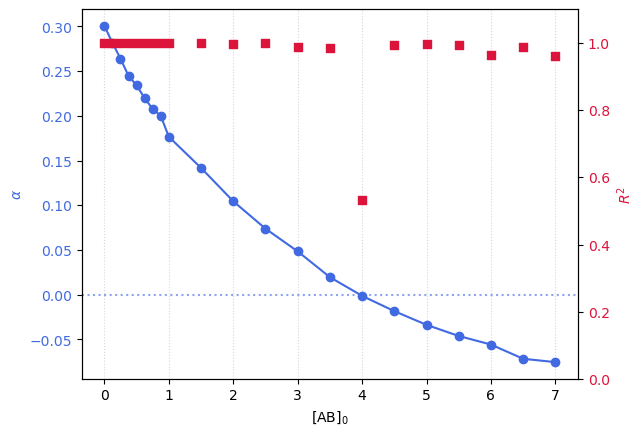

In [107]:
fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$[\text{AB}]_0$') 
ax1.set_ylabel(r'$\alpha$', color="royalblue")
ax1.plot(fit['Condition'], fit['Alpha'], 
            color="royalblue", marker='o')

ax1.tick_params(axis='y', labelcolor="royalblue")
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= "royalblue", alpha= 0.6, linestyle=":")

ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color="crimson")  
ax2.scatter(fit['Condition'], fit['R^2'], 
            color="crimson", marker='s')
ax2.tick_params(axis='y', labelcolor="crimson")
ax2.set_ylim((0,1.1))


Regression completed. Fitted Scaling Constant A: 1209.270
Fitted exponential rate m (alpha): -0.001
Coefficient of Determination (R^2): 0.5337


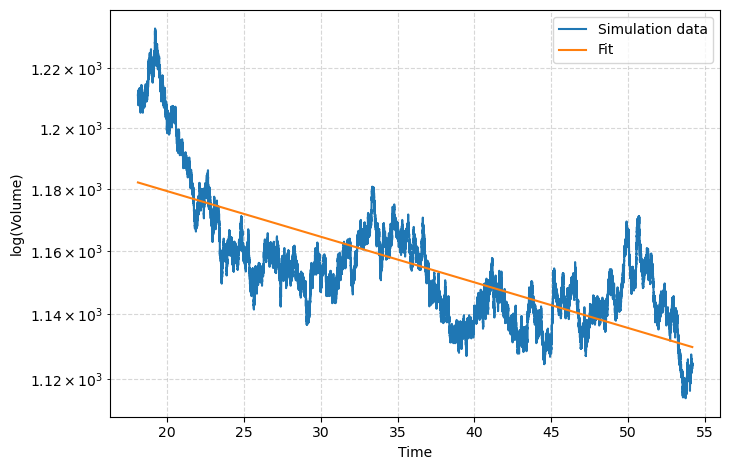

Plot generated successfully.


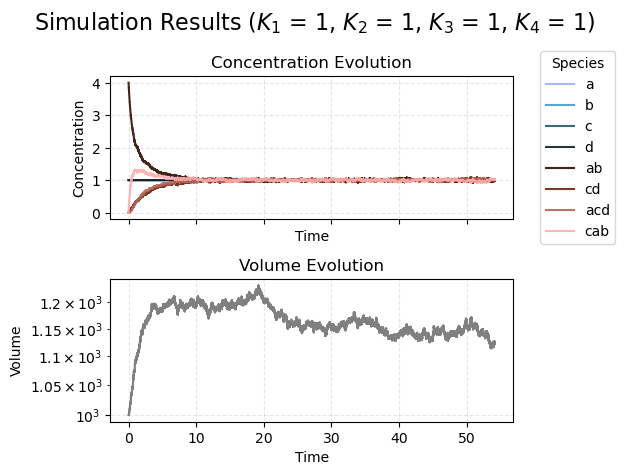

In [108]:
k= [1]*8
abundances, times, volumes = barrido_ab[4]
plot_ajuste(volumes[round(len(volumes)/3):], times[round(len(times)/3):])
plot(abundances, times, volumes, species)

(0.0, 1.1)

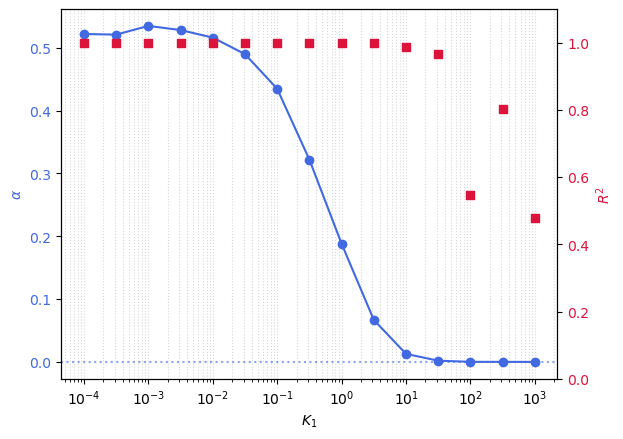

In [109]:
fit = get_alpha_global(barrido_k0)
fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$K_1$') 
ax1.set_ylabel(r'$\alpha$', color="royalblue")
ax1.plot(1/fit['Condition'], fit['Alpha'], 
            color="royalblue", marker='o')
ax1.set_xscale('log')

ax1.tick_params(axis='y', labelcolor="royalblue")
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= "royalblue", alpha= 0.6, linestyle=":")

ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color="crimson")  
ax2.scatter(1/fit['Condition'], fit['R^2'], 
            color="crimson", marker='s')
ax2.tick_params(axis='y', labelcolor="crimson")
ax2.set_xscale('log')
ax2.set_ylim((0,1.1))

In [110]:
barrido_k0.keys()

dict_keys([0.001, 0.0031622776601683794, 0.01, 0.03162277660168379, 0.1, 0.31622776601683794, 1.0, 3.1622776601683795, 10.0, 31.622776601683793, 100.0, 316.22776601683796, 1000.0, 3162.2776601683795, 10000.0])

Regression completed. Fitted Scaling Constant A: 798.554
Fitted exponential rate m (alpha): -0.000
Coefficient of Determination (R^2): 0.4789


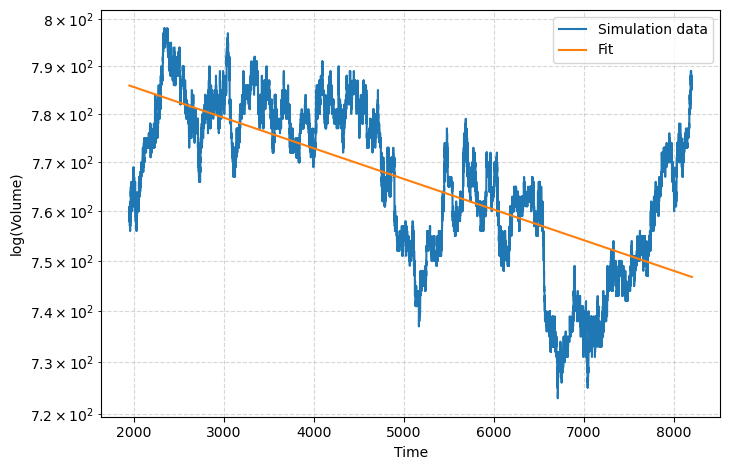

Plot generated successfully.


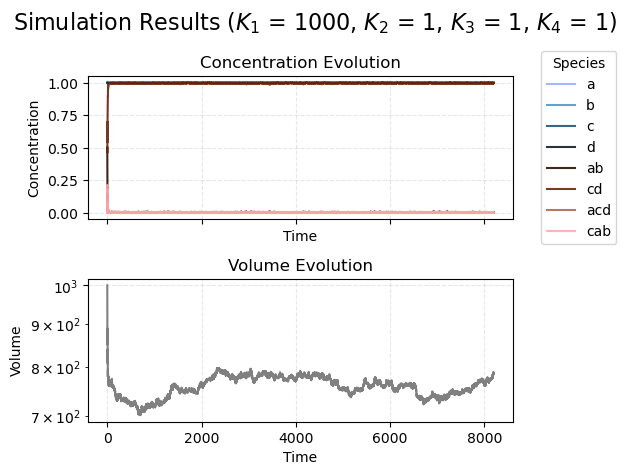

In [111]:
k = [0.001] + [1]*7
abundances, times, volumes = barrido_k0[0.001]
plot_ajuste(volumes[int(len(volumes)/3):], times[int(len(times)/3):])
plot(abundances, times, volumes, species)

(0.0, 1.1)

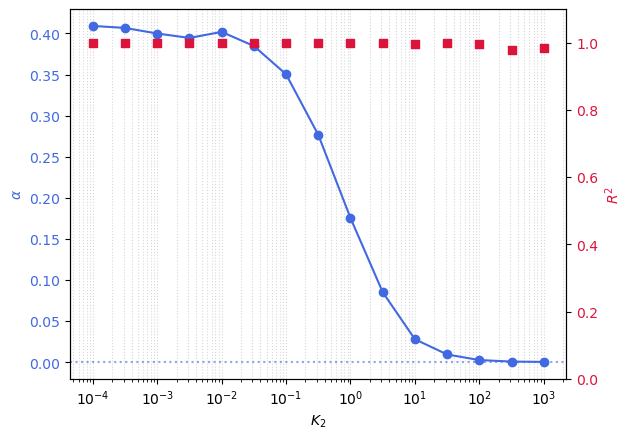

In [112]:
fit = get_alpha_global(barrido_k2)
fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$K_2$') 
ax1.set_ylabel(r'$\alpha$', color="royalblue")
ax1.plot(1/fit['Condition'], fit['Alpha'], 
            color="royalblue", marker='o')
ax1.set_xscale('log')

ax1.tick_params(axis='y', labelcolor="royalblue")
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= "royalblue", alpha= 0.6, linestyle=":")

ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color="crimson")  
ax2.scatter(1/fit['Condition'], fit['R^2'], 
            color="crimson", marker='s')
ax2.tick_params(axis='y', labelcolor="crimson")
ax2.set_ylim((0,1.1))

In [113]:
barrido_k2.keys()

dict_keys([0.001, 0.0031622776601683794, 0.01, 0.03162277660168379, 0.1, 0.31622776601683794, 1.0, 3.1622776601683795, 10.0, 31.622776601683793, 100.0, 316.22776601683796, 1000.0, 3162.2776601683795, 10000.0])

Regression completed. Fitted Scaling Constant A: 923.549
Fitted exponential rate m (alpha): 0.000
Coefficient of Determination (R^2): 0.9842


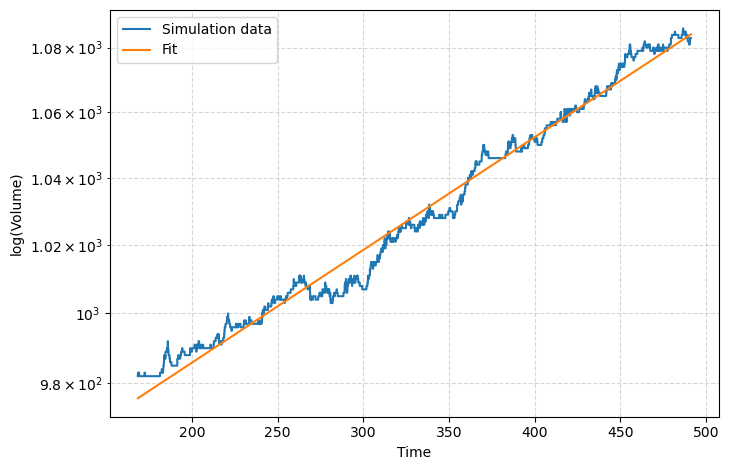

Plot generated successfully.


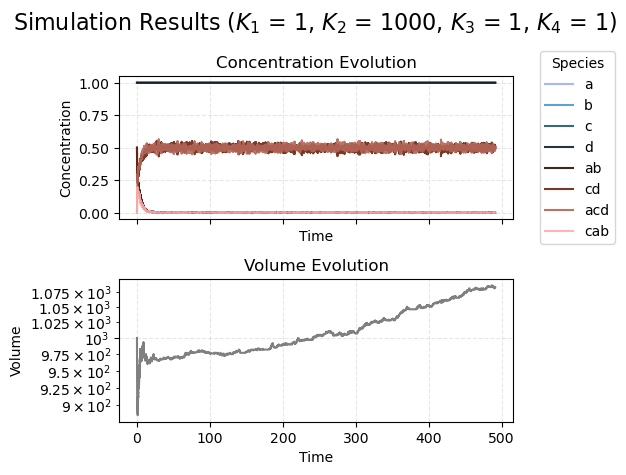

Regression completed. Fitted Scaling Constant A: 905.306
Fitted exponential rate m (alpha): 0.001
Coefficient of Determination (R^2): 0.9783


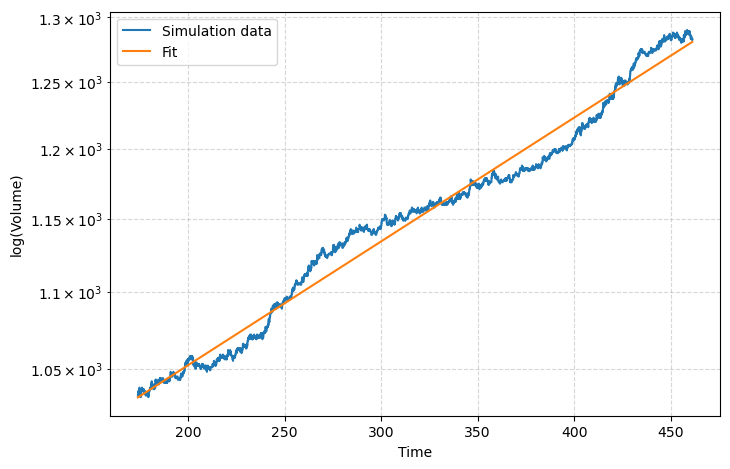

Plot generated successfully.


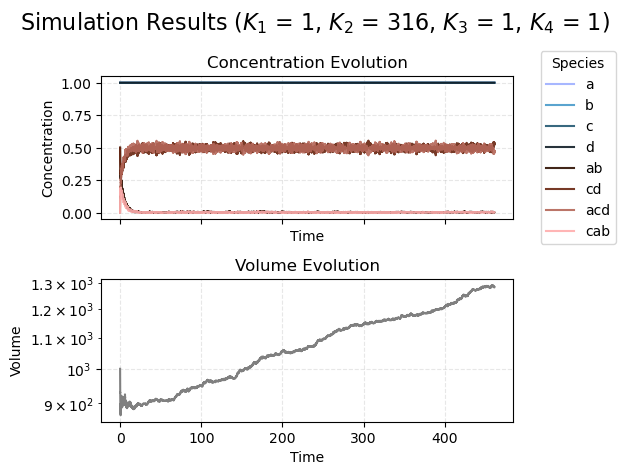

Regression completed. Fitted Scaling Constant A: 872.409
Fitted exponential rate m (alpha): 0.003
Coefficient of Determination (R^2): 0.9957


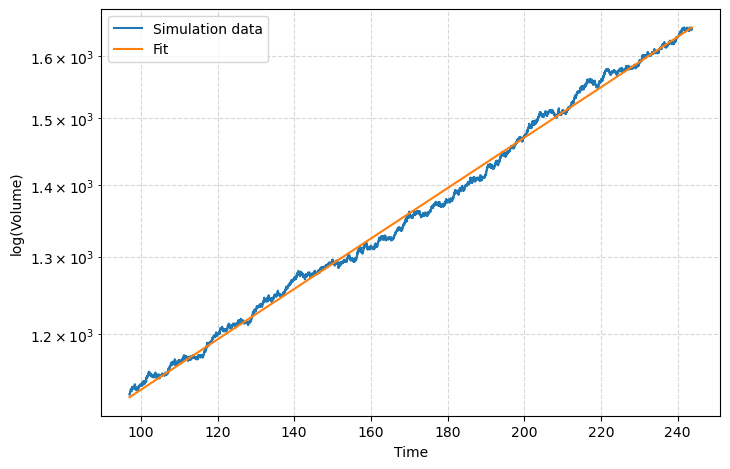

Plot generated successfully.


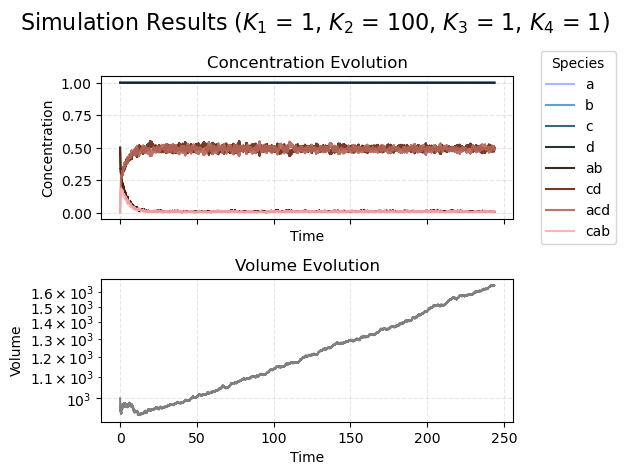

Regression completed. Fitted Scaling Constant A: 880.956
Fitted exponential rate m (alpha): 0.009
Coefficient of Determination (R^2): 0.9977


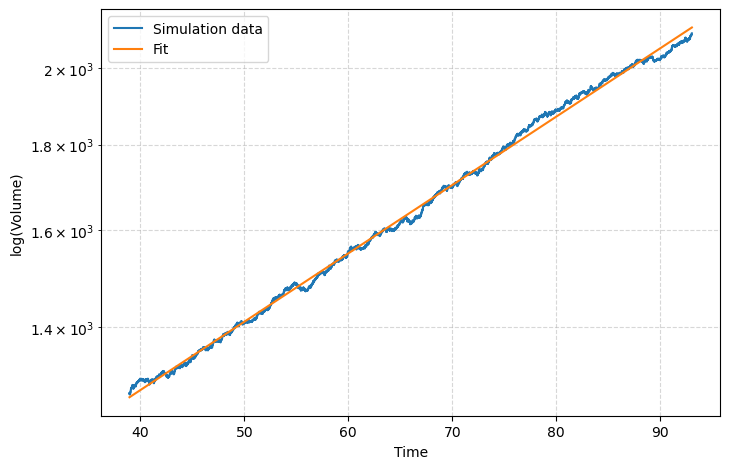

Plot generated successfully.


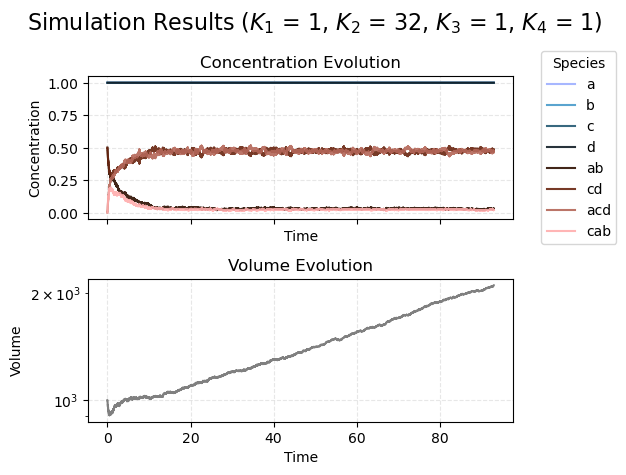

Regression completed. Fitted Scaling Constant A: 949.784
Fitted exponential rate m (alpha): 0.028
Coefficient of Determination (R^2): 0.9976


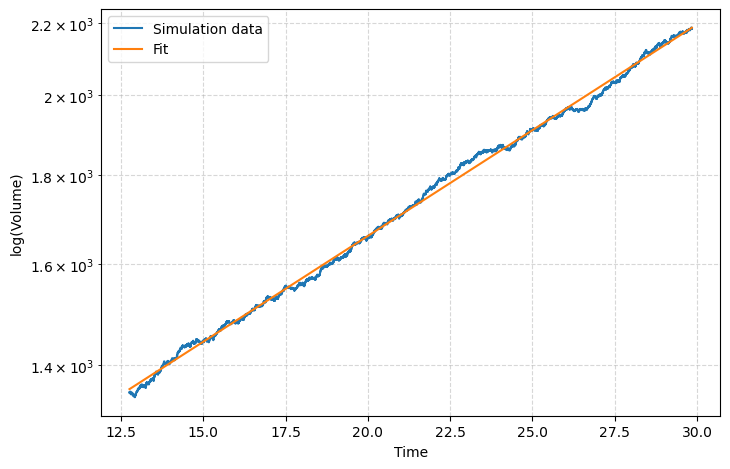

Plot generated successfully.


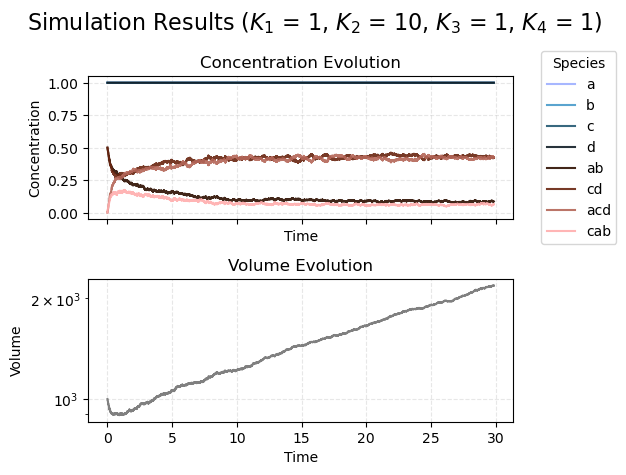

In [114]:
for k_i in [0.001, 0.0031622776601683794, 0.01, 0.03162277660168379, 0.1]:
    k = [1]*2 + [k_i] + [1]*5
    abundances, times, volumes = barrido_k2[k_i]
    plot_ajuste(volumes[int(len(volumes)/3):], times[int(len(times)/3):])
    plot(abundances, times, volumes, species)
    

## curiosas: vol no crece

# condiciones iniciales

105
395


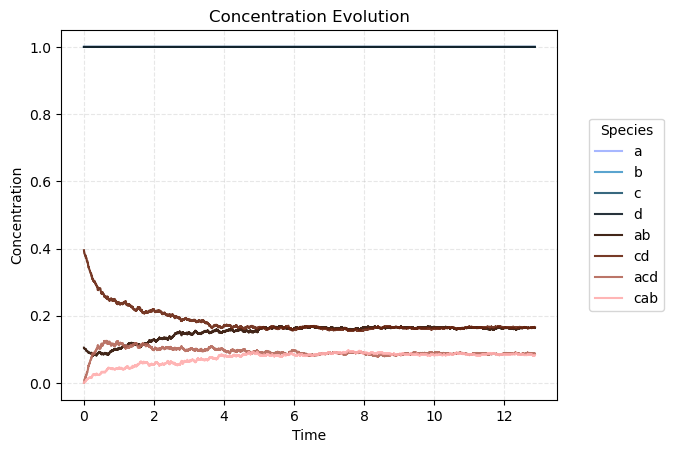

171
329


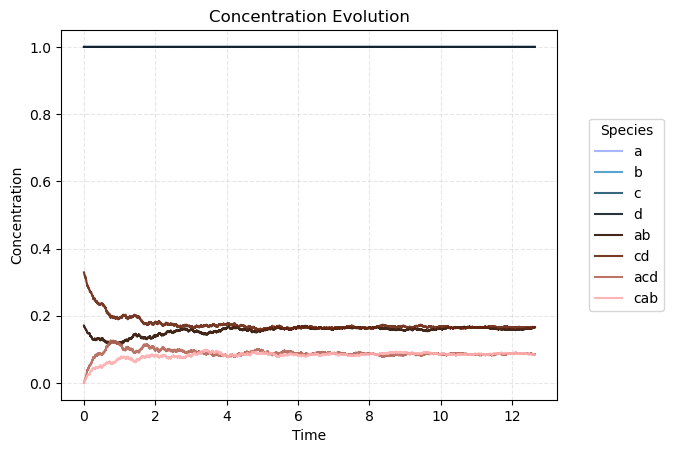

218
282


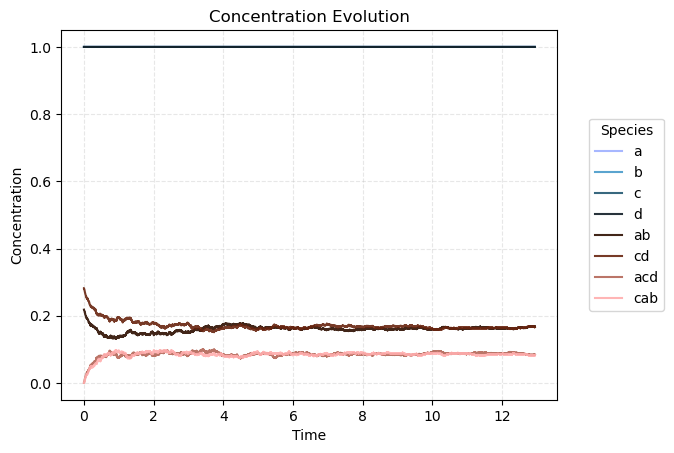

13
487


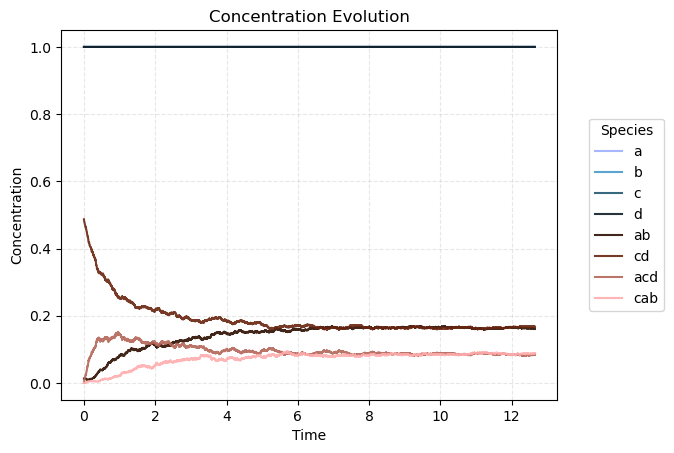

361
139


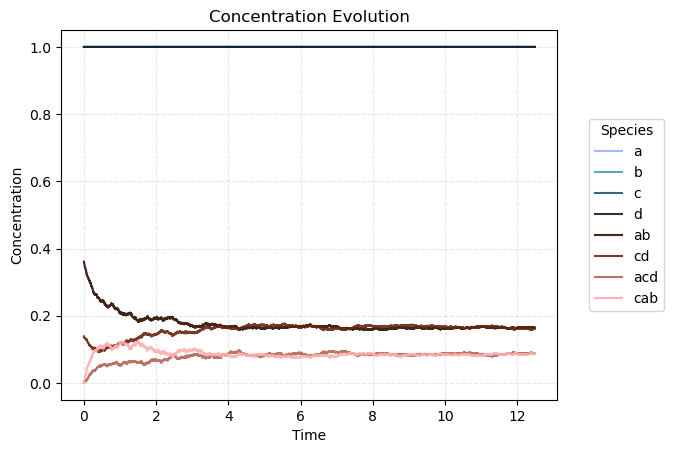

114
886


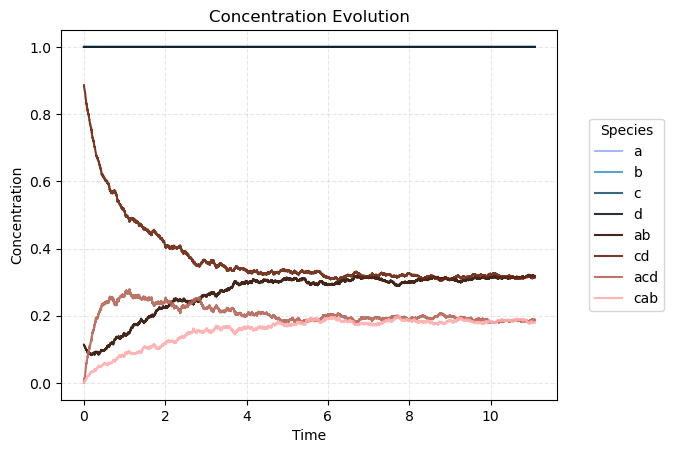

797
203


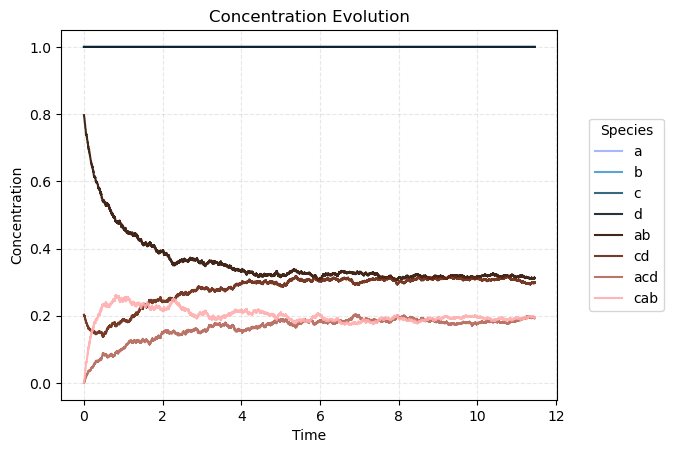

860
140


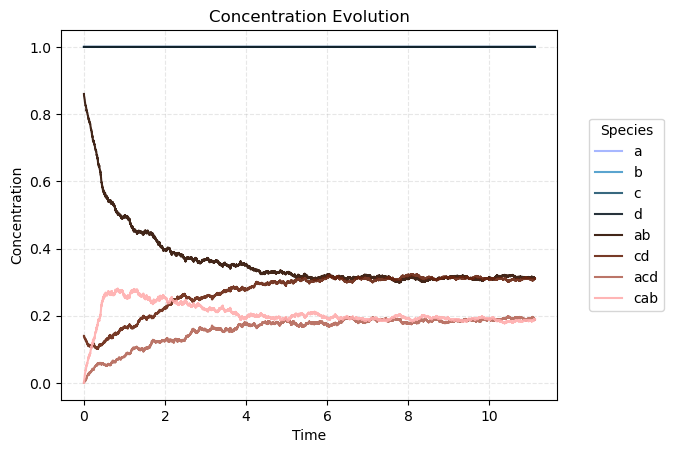

737
263


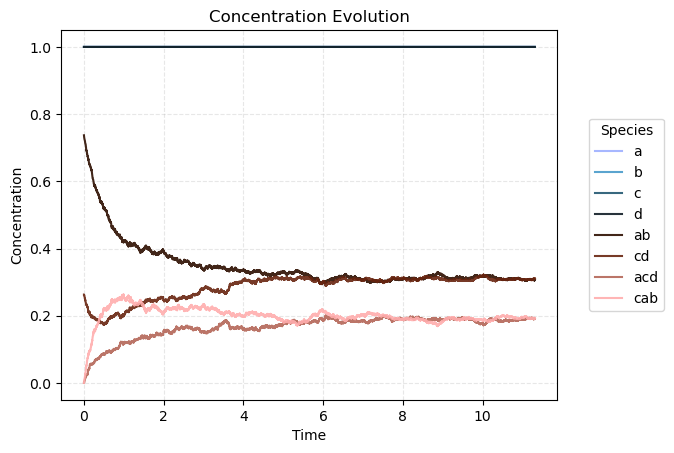

529
471


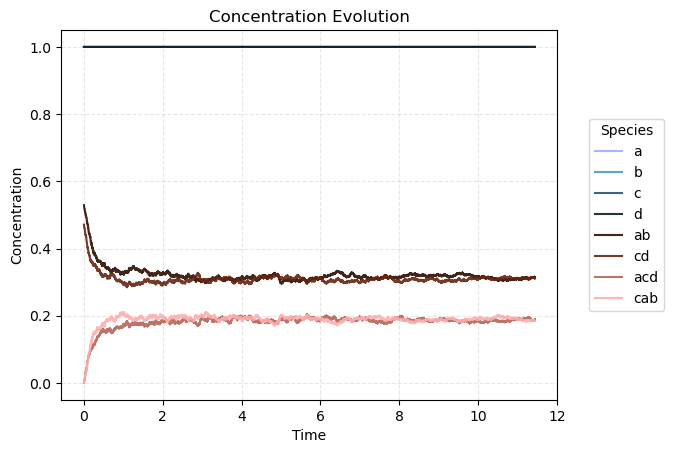

1754
246


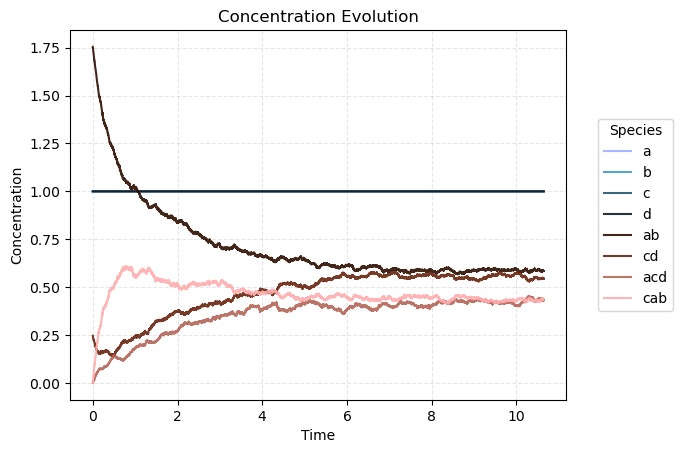

1546
454


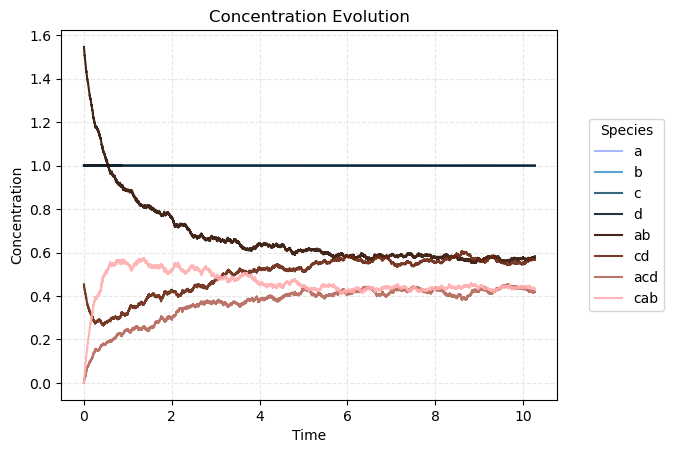

1885
115


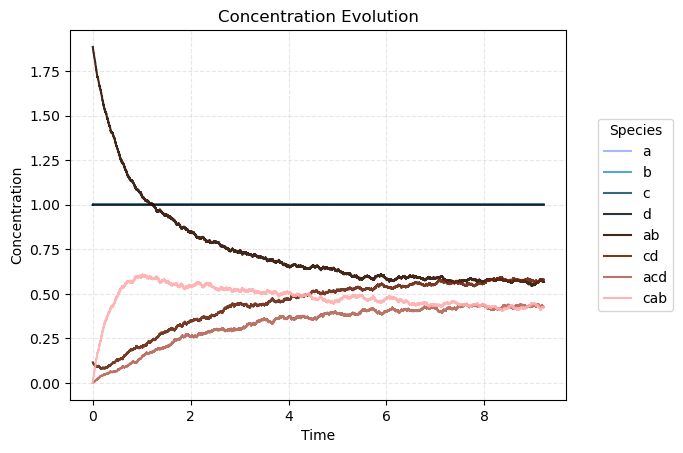

1986
14


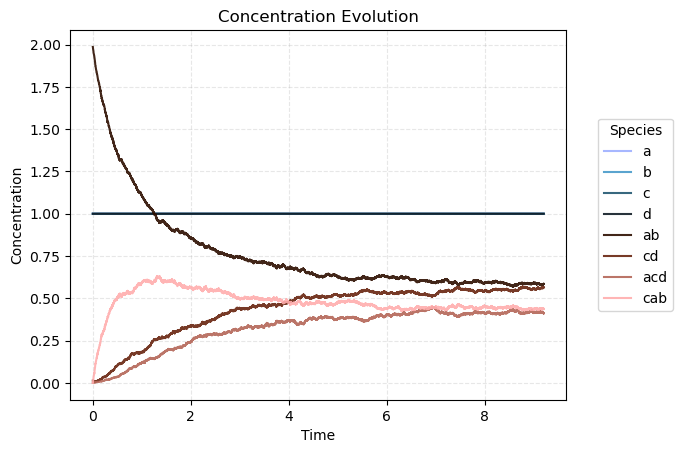

1834
166


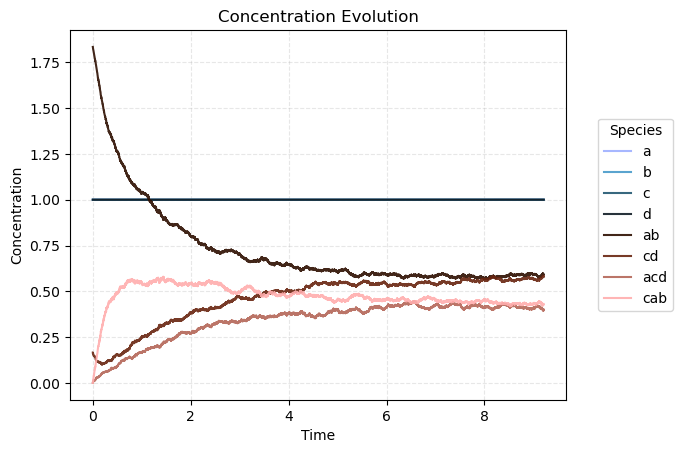

In [12]:
from random import random
n_iterations = 1e5
method = "Protocell" # Gillespie or Deterministic
# Reaction constants:
k = [1]*8 # len(k)= # de reacciones
# Volume:
V = 1000
initial_food = [1000]*4 + [0]*4 # initial molecules number

concentrations = [0.5,1,2]

for i in concentrations:
    total_abundance = i * V
    for j in range(5):
        random_number = random()
        initial_food[4] = round(random_number * total_abundance)
        initial_food[5] = round(total_abundance - (random_number * total_abundance))
        print(initial_food[4])
        print(initial_food[5])
        abundances, times, volumes = chemistry(method, n_iterations, reactions,
                                initial_food, k, V)
        
        plot_concentration(abundances, times, volumes)

## catalizador mínimo

1


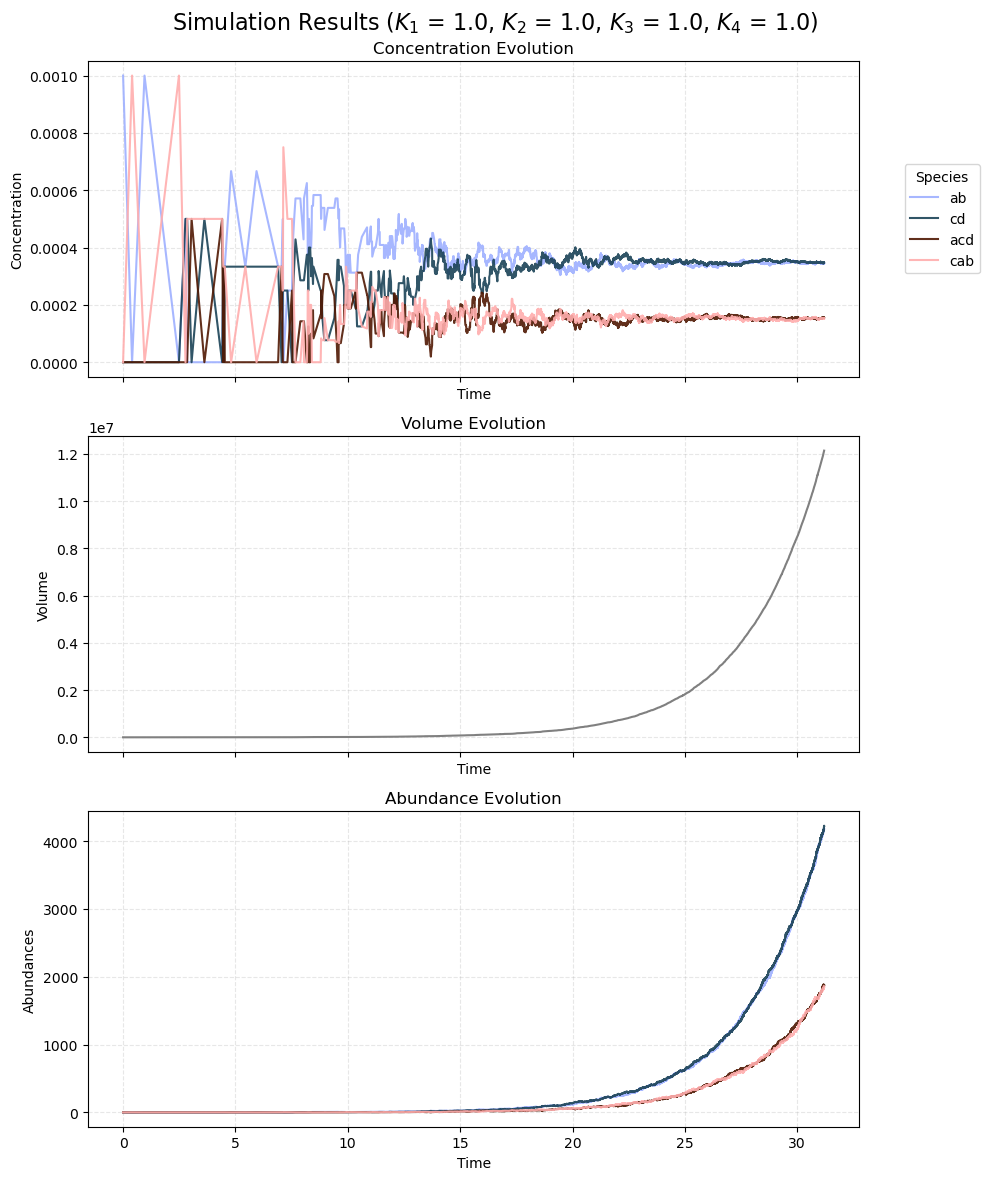

11


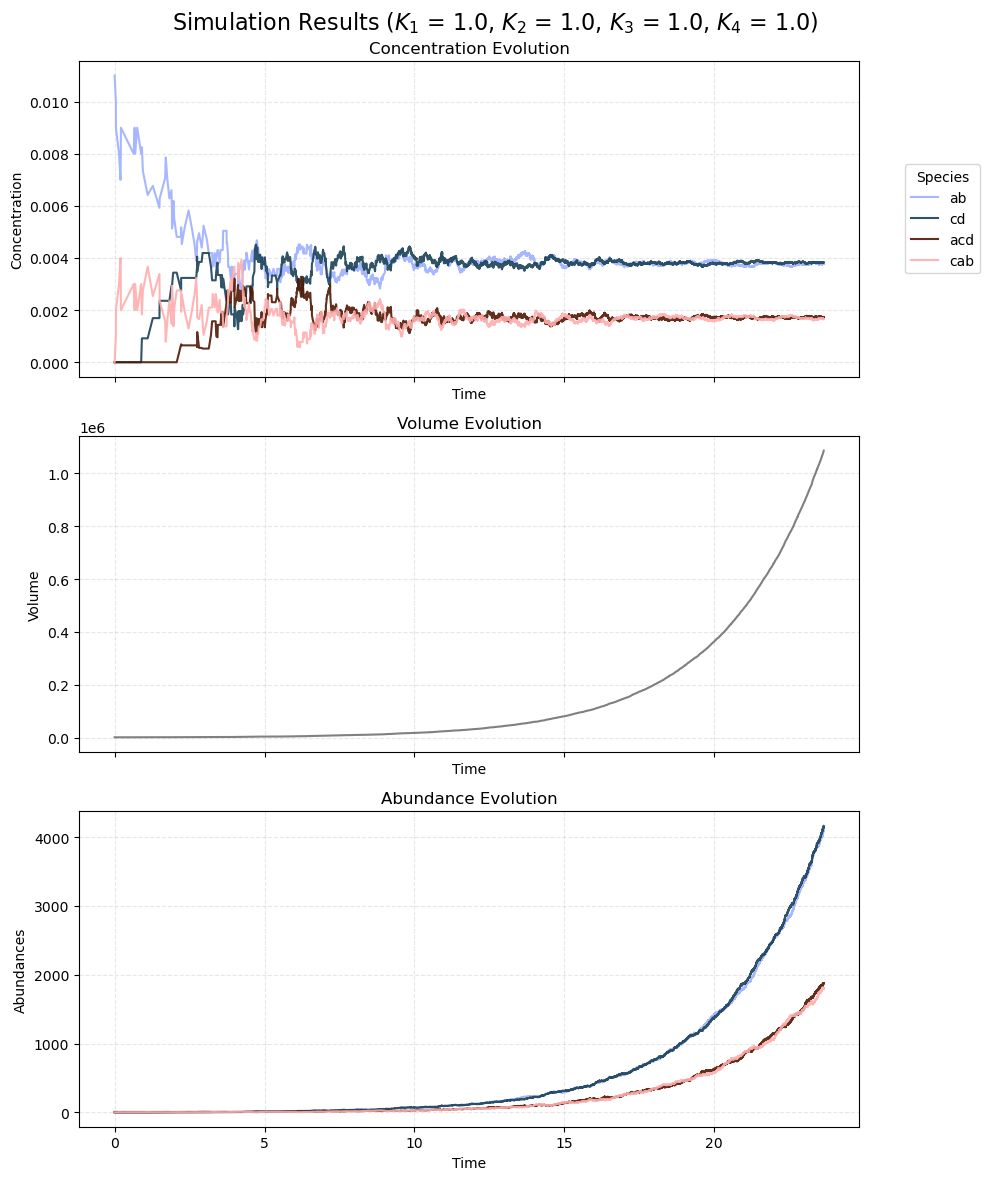

21


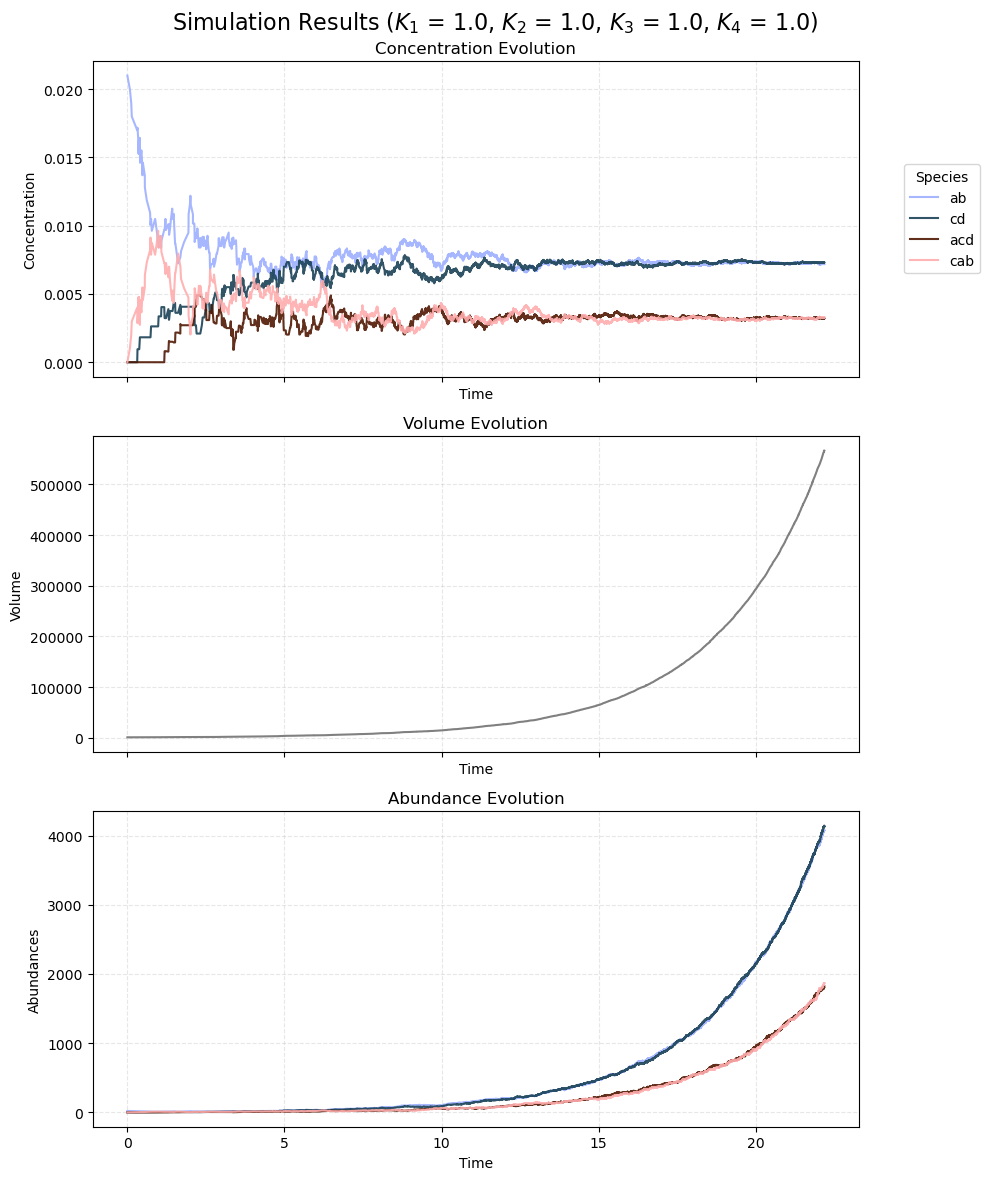

31


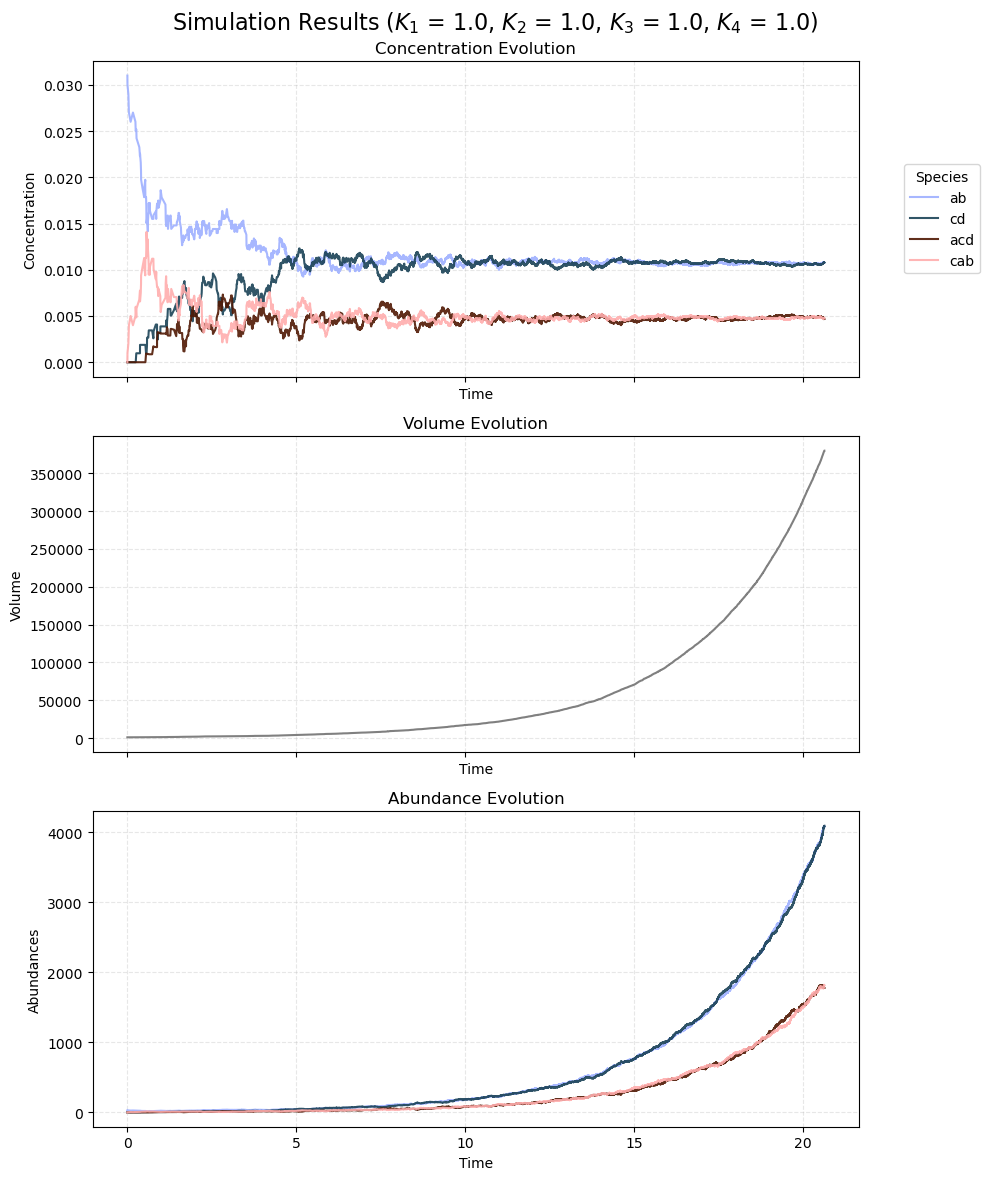

41


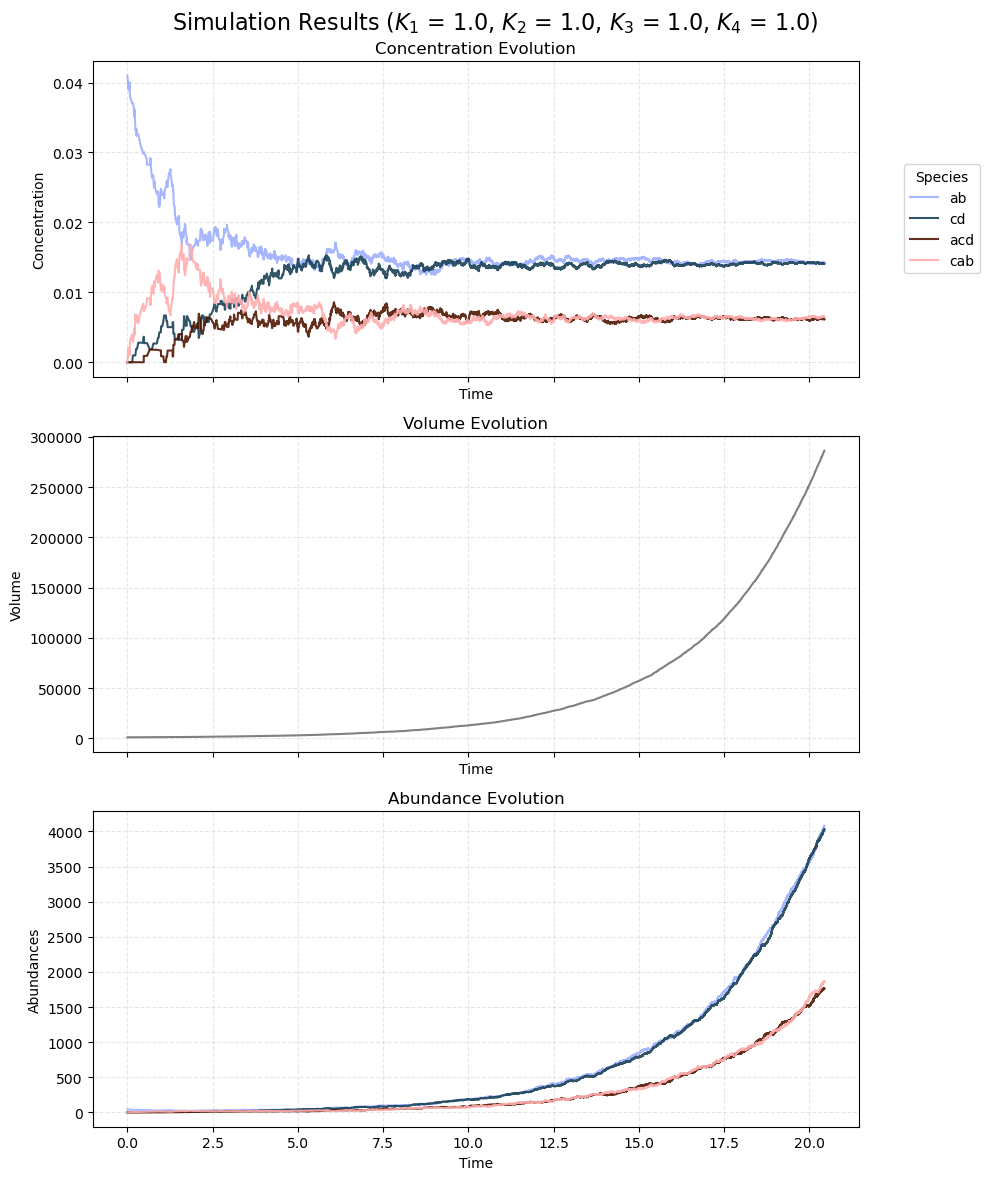

51


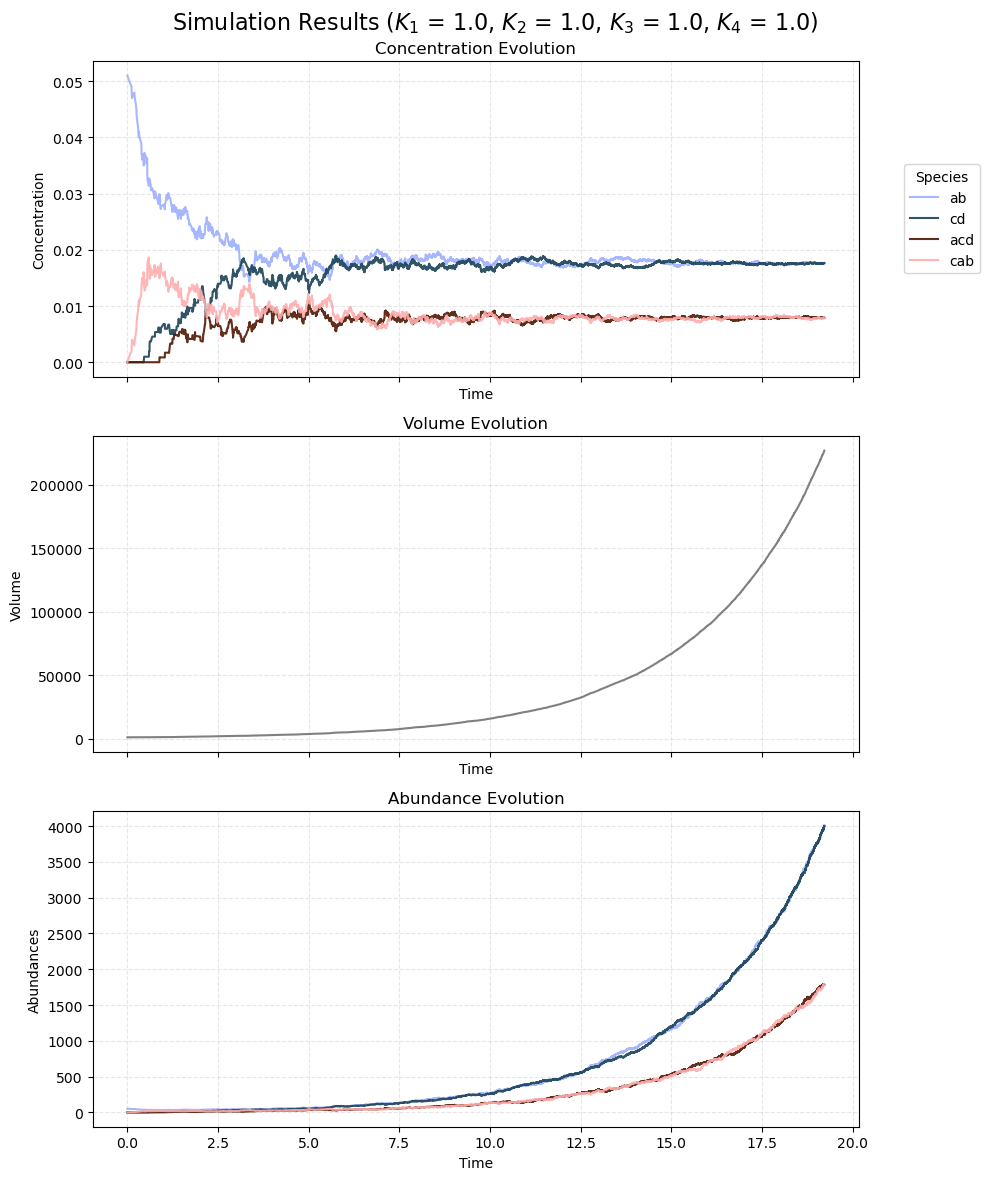

61


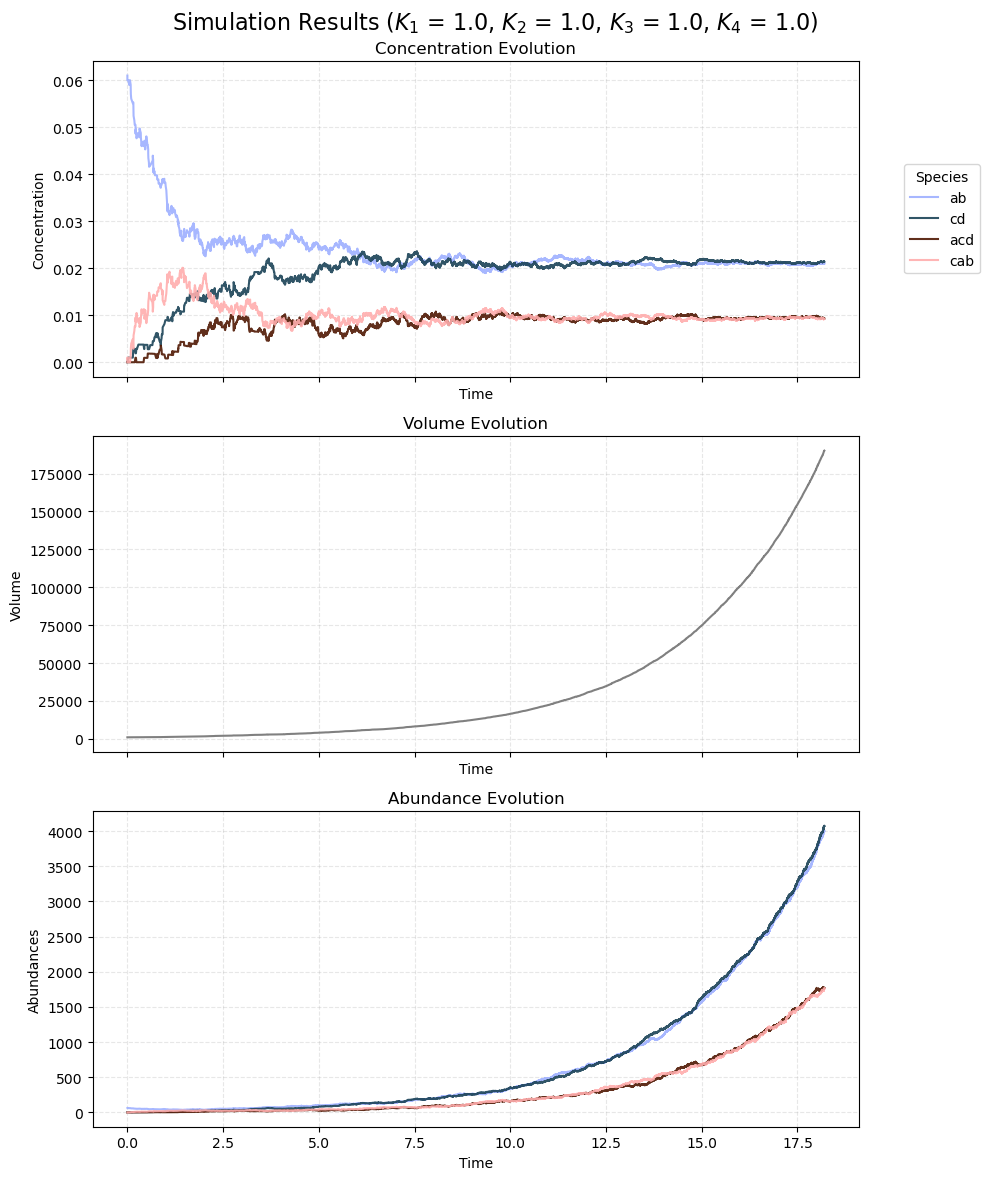

71


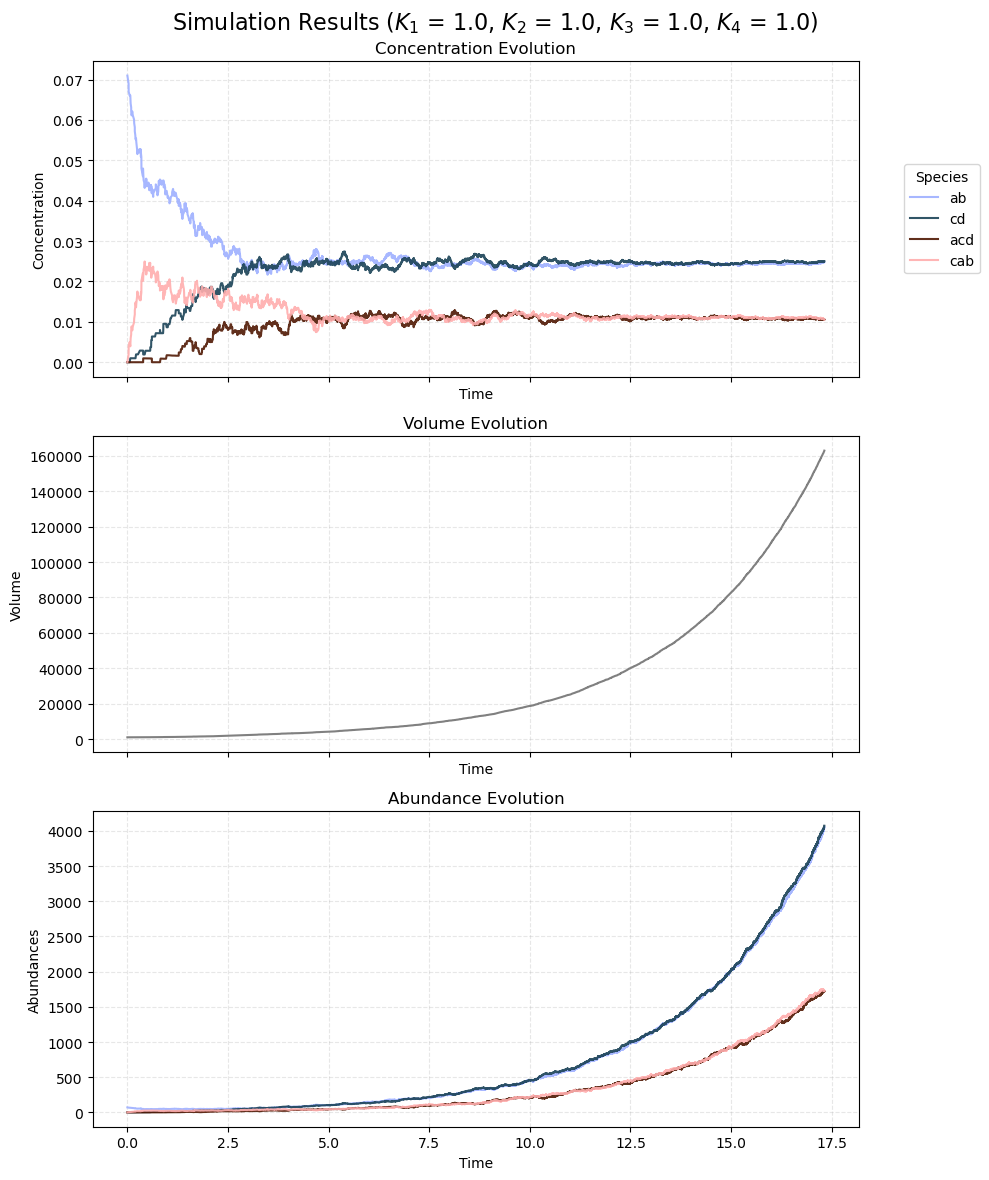

81


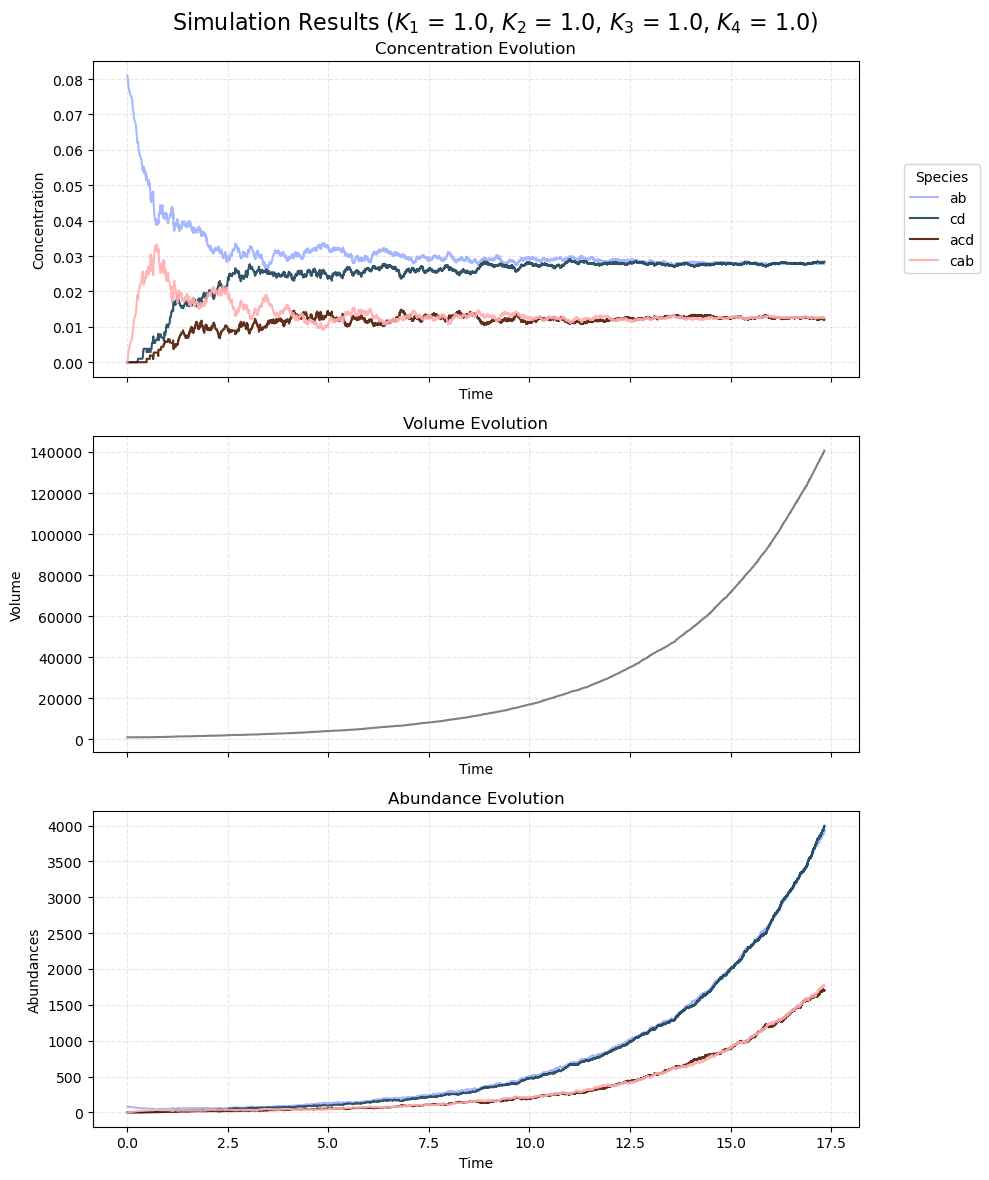

91


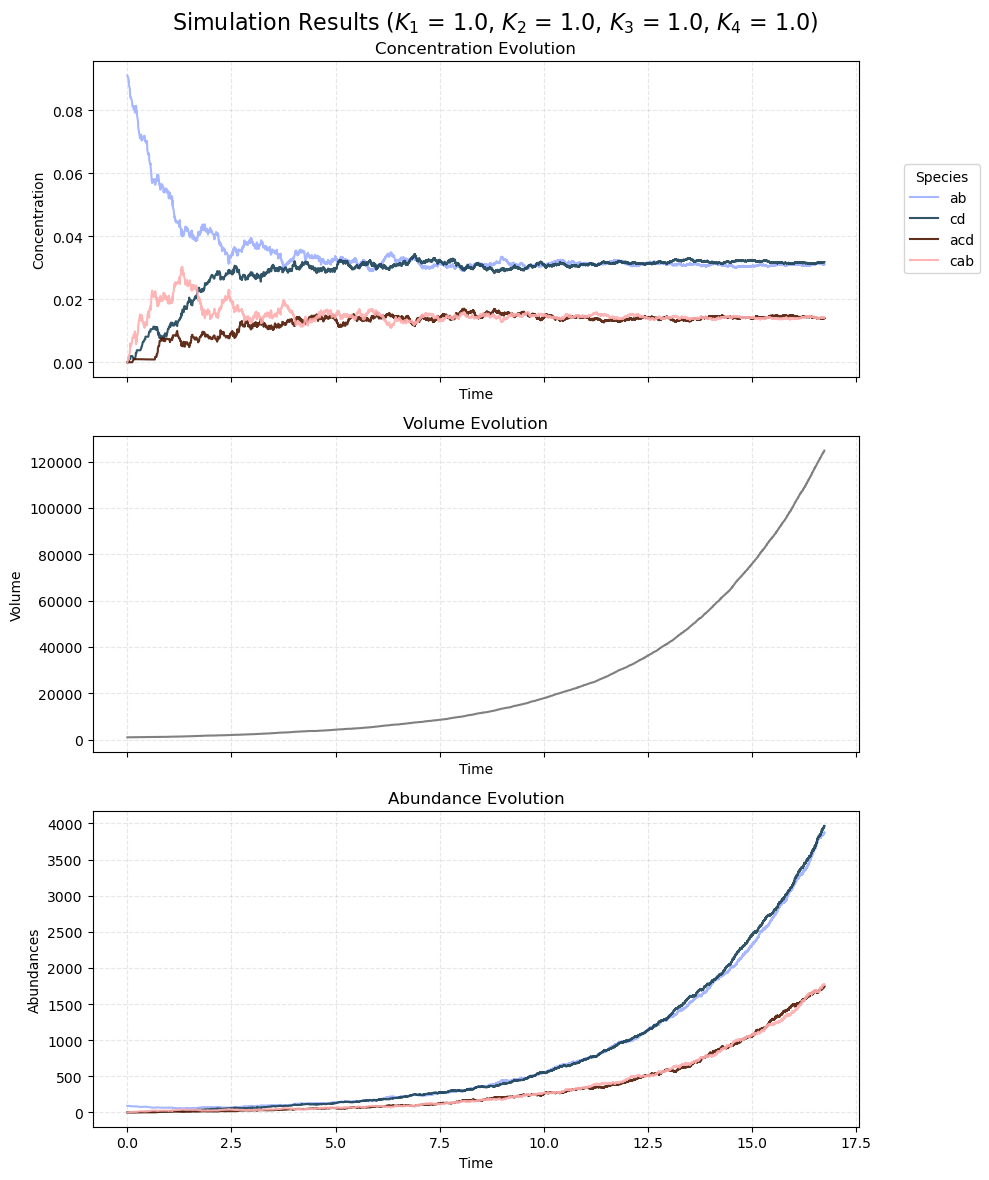

In [11]:
n_iterations = 1e5
method = "Protocell" # Gillespie or Deterministic
# Reaction constants:
k = [1]*8 # len(k)= # de reacciones
# Volume:
V = 1000
initial_food = [1000]*4 + [0]*4 # initial molecules number

catal_abundances = range(1,100,10)

for total_abundance in catal_abundances:
    initial_food[4] = total_abundance
    print(initial_food[4])
    abundances, times, volumes = chemistry(method, n_iterations, reactions,
                            initial_food, k, V)
    
    plot(abundances[:,4:], times, volumes, species[4:])

# figura molona barrido

In [10]:
from random import random
n_iterations = 2e5
method = "Protocell" # Gillespie or Deterministic
# Reaction constants:
k = [1]*8 # len(k)= # de reacciones
# Volume:
V = 1000
initial_food = [1000]*4 + [0]*4 # initial molecules number
concentration = 1
final_concentrations = []
initial_conditions = []

total_abundance = concentration * V
for i in range(11):
    for j in range(4, len(species)):
        initial_food[j] = random()
        
    total_0 = sum(initial_food[4:])
    for j in range(4, len(species)):
        initial_food[j] = (initial_food[j]/total_0)*concentration*V
    
    print(f"Performing simulation for\
          [ab] = {initial_food[4]},\
          [cd] = {initial_food[5]},\
          [acd] = {initial_food[6]},\
              [cab] = {initial_food[7]}")
    
    abundances, times, volumes = chemistry(method, n_iterations, reactions,
                            initial_food, k, V)
    
    concentrations = (abundances.T / volumes).T
    
    initial_conditions.append(initial_food[4:])
    final_concentrations.append(np.mean(concentrations[-500:,4:], axis= 0))
    
initial_conditions = np.array(initial_conditions)
final_concentrations = np.array(final_concentrations)        

Performing simulation for          [ab] = 200.65175947809857,          [cd] = 285.22268312430526,          [acd] = 187.4155906476895,              [cab] = 326.70996674990664
Performing simulation for          [ab] = 390.8617747864471,          [cd] = 65.83869394432156,          [acd] = 398.12220280340927,              [cab] = 145.17732846582214
Performing simulation for          [ab] = 87.1694097243349,          [cd] = 388.43250883537576,          [acd] = 267.6366815427087,              [cab] = 256.76139989758065
Performing simulation for          [ab] = 243.20327477054946,          [cd] = 420.8961052494592,          [acd] = 263.8273233388314,              [cab] = 72.07329664115994
Performing simulation for          [ab] = 274.50462977209224,          [cd] = 223.24188094050038,          [acd] = 387.5311036278958,              [cab] = 114.7223856595117
Performing simulation for          [ab] = 362.3479409851989,          [cd] = 181.30743721451725,          [acd] = 153.48223714914914,   

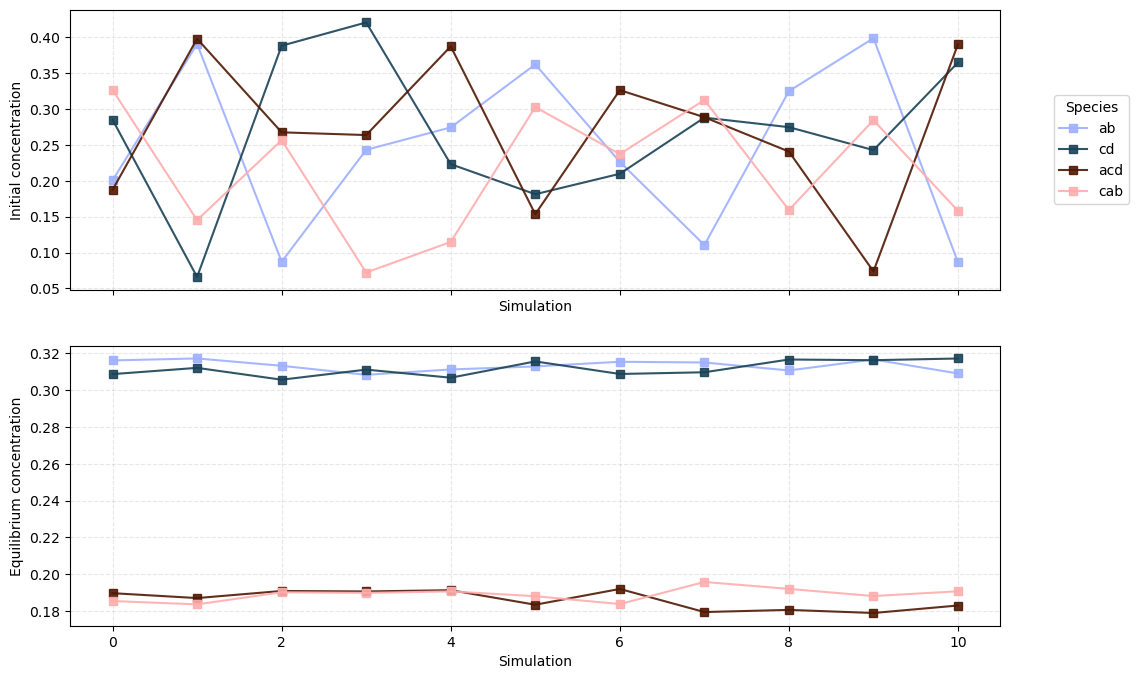

In [14]:
plot_barrido(initial_conditions/V, final_concentrations, species[4:])


# figura cambio de vol con condicion inicial

In [32]:
n_iterations = 1.5e5
method = "Protocell" # Gillespie or Deterministic
# Reaction constants:
k = [1]*8 # len(k)= # de reacciones
# Volume:
V = 1000
initial_food = [1000]*4 + [0]*4 # initial molecules number
final_volume = []
initial_ab = np.linspace(1000,7000,6)

for ab in initial_ab:
    initial_food[4] = ab
    print(f"Performing simulation for [ab]={ab}")
    abundances, times, volumes = chemistry(method, n_iterations, reactions,
                            initial_food, k, V)
    print(f"Simulation ended. Final volume = {volumes[-1]}")
    
    try:
        print(f"Volume at t= 10 = {volumes[times>10][0]}")
        final_volume.append(volumes[times>10][0])
    except IndexError:
        final_volume.append(volumes[-1])
    

Performing simulation for [ab]=1000.0
Simulation ended. Final volume = 7198.0
Volume at t= 10 = 6065.0
Performing simulation for [ab]=2200.0
Simulation ended. Final volume = 2346.363636363636
Performing simulation for [ab]=3400.0
Simulation ended. Final volume = 1476.1764705882354
Performing simulation for [ab]=4600.0
Criterion for stop was # of iterations
Simulation ended. Final volume = 923.913043478261
Volume at t= 10 = 1032.1739130434783
Performing simulation for [ab]=5800.0
Criterion for stop was # of iterations
Simulation ended. Final volume = 547.5862068965517
Volume at t= 10 = 738.6206896551724
Performing simulation for [ab]=7000.0
Criterion for stop was # of iterations
Simulation ended. Final volume = 435.0
Volume at t= 10 = 577.8571428571429


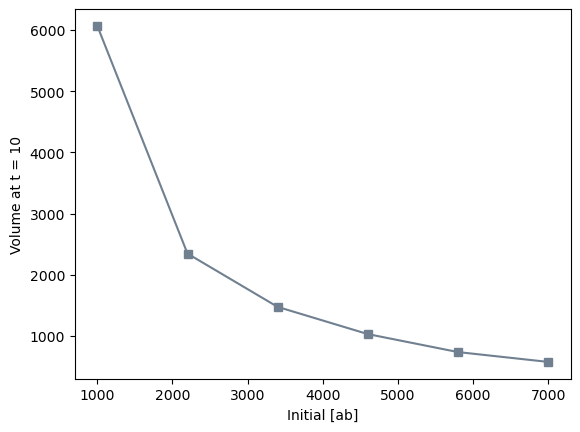

In [35]:
plot_volume(final_volume, initial_ab)

# cambio de volumen con K

In [91]:
n_iterations = 5e5
method = "Protocell" # Gillespie or Deterministic
# Reaction constants:
k = [1]*8 # len(k)= # de reacciones
# Volume:
V = 1000
initial_food = [1000]*4 + [500]*2 + [0]*2 # initial molecules number
final_volume = []
k_change = np.logspace(-3,4,8)
simulations_k = {}

for k_i in k_change:
    k[0] = k_i
    print(f"Performing simulation for k = {k_i}")
    abundances, times, volumes = chemistry(method, n_iterations, f,
                            initial_food, k, V)
    print(f"Simulation ended. Final volume = {volumes[-1]}")
    simulations_k[k_i] = (abundances, times, volumes)

Performing simulation for k = 0.001
Simulation ended. Final volume = 909.0
Performing simulation for k = 0.01
Simulation ended. Final volume = 895.0
Performing simulation for k = 0.1
Simulation ended. Final volume = 1908.0
Performing simulation for k = 1.0
Simulation ended. Final volume = 6856.0
Performing simulation for k = 10.0
Simulation ended. Final volume = 11155.0
Performing simulation for k = 100.0
Simulation ended. Final volume = 12082.0
Performing simulation for k = 1000.0
Simulation ended. Final volume = 12264.0
Performing simulation for k = 10000.0
Simulation ended. Final volume = 12417.0


In [96]:
with open("simulacion_barrido_k1.txt", "ab") as file:
    pickle.dump(simulations_k, file)

In [93]:
fit = get_alpha_global(simulations_k)
print(fit.to_string(index=False, float_format="%.4f"))

 Initial [AB]  Alpha  Scaling Const. (A)    R^2
       0.0010 0.0000            858.3199 0.1078
       0.0100 0.0000            884.9649 0.0809
       0.1000 0.0123            831.4480 0.9918
       1.0000 0.1773            907.0835 0.9996
      10.0000 0.4391            916.7888 0.9999
     100.0000 0.5020           1099.3846 0.9998
    1000.0000 0.5226           1038.4913 0.9999
   10000.0000 0.5250           1083.3958 0.9999


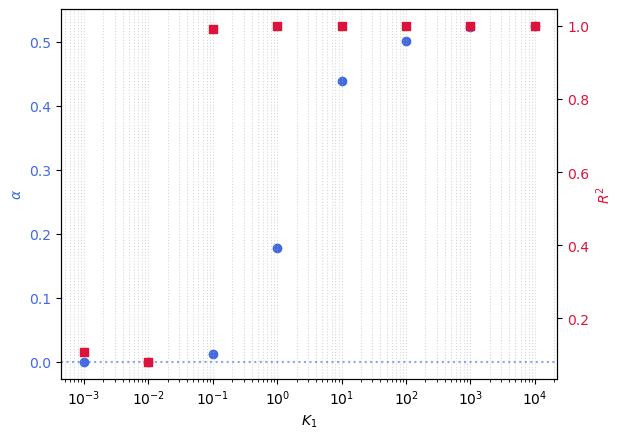

In [ ]:
fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$K_1$') 
ax1.set_ylabel(r'$\alpha$', color="royalblue")
ax1.scatter(fit['Initial [AB]'], fit['Alpha'], 
            color="royalblue", marker='o')

ax1.tick_params(axis='y', labelcolor="royalblue")
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= "royalblue", alpha= 0.6, linestyle=":")
ax1.set_xscale("log")
ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color="crimson")  
ax2.scatter(fit['Initial [AB]'], fit['R^2'], 
            color="crimson", marker='s')
ax2.set_xscale("log")
ax2.tick_params(axis='y', labelcolor="crimson")

In [18]:
with open("simulacion_barrido_k1.txt", "rb") as file:
    simulations_k = pickle.load(file)

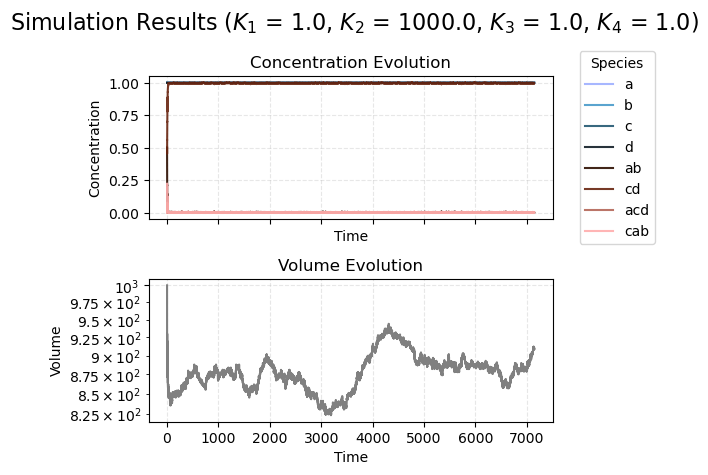

Regression completed. Fitted Scaling Constant A: 858.322
Fitted exponential rate m (alpha): 0.000
Coefficient of Determination (R^2): 0.1078


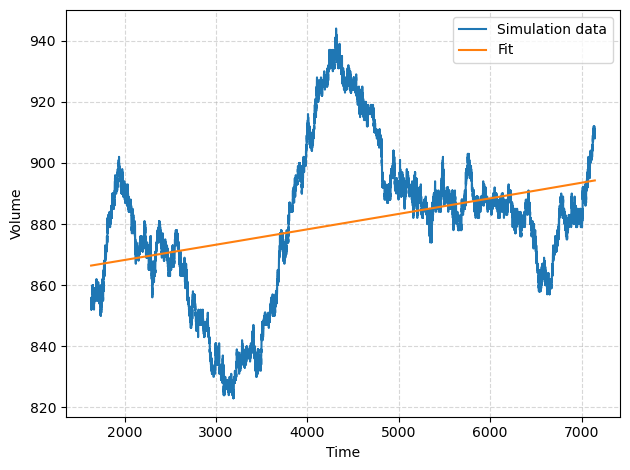

Plot generated successfully.


In [28]:
abundances, times, volumes = simulations_k[0.001]
plot(abundances, times, volumes, species)
plot_ajuste(volumes[round(len(volumes)/3):], times[round(len(volumes)/3):])

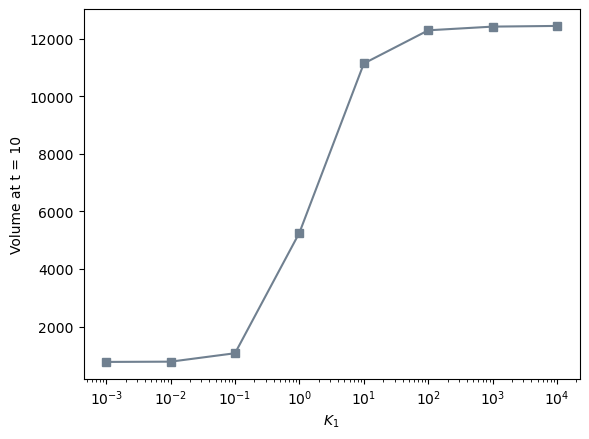

In [58]:
plot_volume_vs_k(final_volume, k_change, k, 0)

In [ ]:
n_iterations = 5e5
method = "Protocell" # Gillespie or Deterministic
# Reaction constants:
k = [1]*8 # len(k)= # de reacciones
# Volume:
V = 1000
initial_food = [1000]*4 + [500]*2 + [0]*2 # initial molecules number
final_volume = []
k_change = np.logspace(-3,4,8)
simulations_k2 = {}

for k_i in k_change:
    k[2] = k_i
    print(f"Performing simulation for k = {k_i}")
    abundances, times, volumes = chemistry(method, n_iterations, f,
                            initial_food, k, V)
    print(f"Simulation ended. Final volume = {volumes[-1]}")
    simulations_k2[k_i] = (abundances, times, volumes)


Performing simulation for k = 0.001
Criterion for stop was # of iterations
Simulation ended. Final volume = 1049.0
Performing simulation for k = 0.01
Simulation ended. Final volume = 1552.0
Performing simulation for k = 0.1
Simulation ended. Final volume = 2195.0
Performing simulation for k = 1.0
Simulation ended. Final volume = 6858.0
Performing simulation for k = 10.0
Simulation ended. Final volume = 10726.0
Performing simulation for k = 100.0
Simulation ended. Final volume = 11582.0
Performing simulation for k = 1000.0
Simulation ended. Final volume = 11779.0
Performing simulation for k = 10000.0
Simulation ended. Final volume = 11839.0


In [99]:
with open("simulacion_barrido_k2.txt", "ab") as file:
    pickle.dump(simulations_k2, file)

In [11]:
with open("simulacion_barrido_k2.txt", "rb") as file:
    simulations_k2 = pickle.load(file)

In [17]:
fit = get_alpha_global(simulations_k2)
print(fit.to_string(index=False, float_format="%.4f"))

 Initial [AB]  Alpha  Scaling Const. (A)    R^2
       0.0010 0.0002            942.4355 0.9688
       0.0100 0.0029            974.0330 0.9908
       0.1000 0.0271           1002.8551 0.9974
       1.0000 0.1834            834.9446 0.9997
      10.0000 0.3545            906.7202 0.9999
     100.0000 0.3985            964.1442 0.9999
    1000.0000 0.4009           1031.2532 0.9999
   10000.0000 0.3958           1082.4758 0.9996


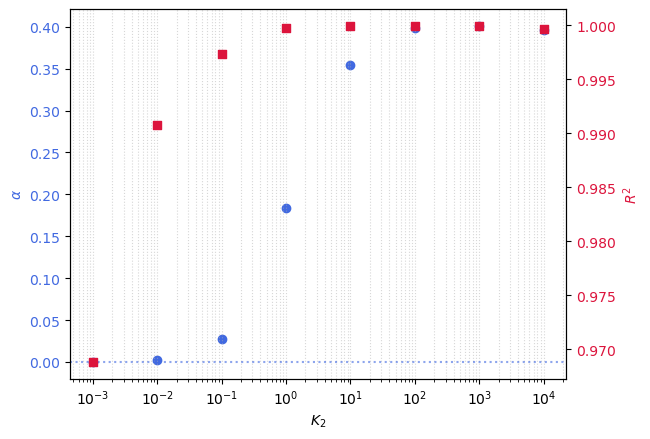

In [18]:
fig, ax1 = plt.subplots()

ax1.set_xlabel(r'$K_2$') 
ax1.set_ylabel(r'$\alpha$', color="royalblue")
ax1.scatter(fit['Initial [AB]'], fit['Alpha'], 
            color="royalblue", marker='o')

ax1.tick_params(axis='y', labelcolor="royalblue")
ax1.grid(True, linestyle=':', alpha=0.5, which='both', axis='x')
ax1.axhline(y= 0, color= "royalblue", alpha= 0.6, linestyle=":")
ax1.set_xscale("log")
ax2 = ax1.twinx()  

ax2.set_ylabel(r'$R^2$', color="crimson")  
ax2.scatter(fit['Initial [AB]'], fit['R^2'], 
            color="crimson", marker='s')
ax2.set_xscale("log")
ax2.tick_params(axis='y', labelcolor="crimson")

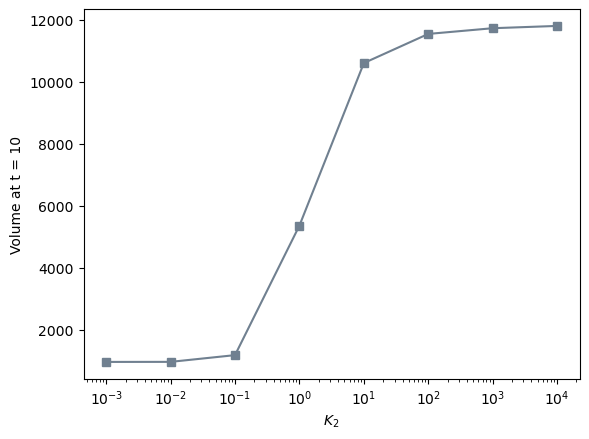

In [60]:
plot_volume_vs_k(final_volume, k_change, k, 2)

In [10]:
abundances, times, volumes = simulations_k2[0.001]

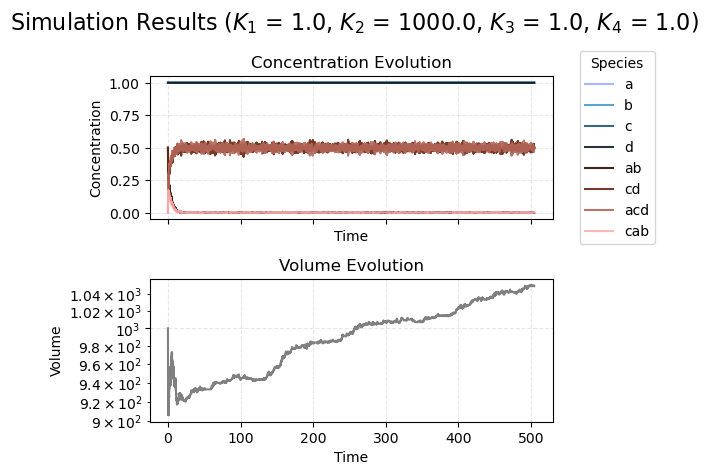

Regression completed. Fitted Scaling Constant A: 942.435
Fitted exponential rate m (alpha): 0.000
Coefficient of Determination (R^2): 0.9688


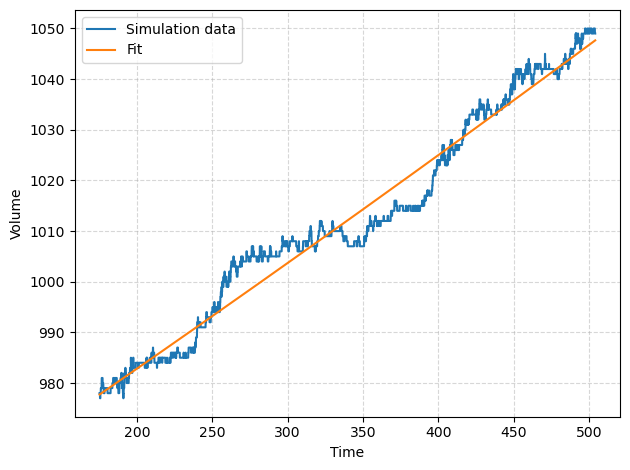

Plot generated successfully.


In [17]:
k= [1,1,0.001,1,1,1,1,1]
plot(abundances, times, volumes, species)
plot_ajuste(volumes[round(len(volumes)/3):], times[round(len(volumes)/3):])


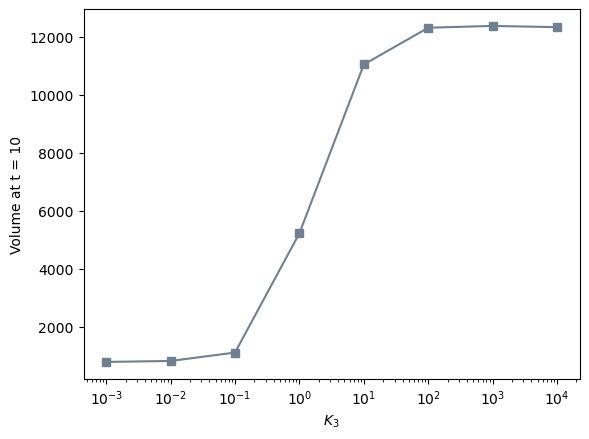

In [12]:
plot_volume_vs_k(final_volume, k_change, k, 4)